In [1]:
# imports

import gym
import random as rd
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

    Observations
    1. On decreasing target update freq the varience of model increasing and on increasing convergence is taking longer
    2. low discount factors unable to clearly differentiate the increase in steps after some treshlod
    3. Increasing mini batch helping to achieve convergence faster
    4. 

In [13]:
# implementing DQN class

class DQN:

    REPLAY_MEMORY_SIZE = 1 			# number of tuples in experience replay  
    EPSILON = 0.5 						# epsilon of epsilon-greedy exploation
    EPSILON_DECAY = 0.999 				# exponential decay multiplier for epsilon
    HIDDEN1_SIZE = 32 					# size of hidden layer 1 --> try 16*
    HIDDEN2_SIZE = 16 					# size of hidden layer 2
    EPISODES_NUM = 2000 				# number of episodes to train on. Ideally shouldn't take longer than 2000
    MAX_STEPS = 200 					# maximum number of steps in an episode 
    LEARNING_RATE = 0.001 				# learning rate and other parameters for SGD/RMSProp/Adam --> try 0.001*, 0.003
    MINIBATCH_SIZE = 1 				# size of minibatch sampled from the experience replay --> try 16*, 8
    DISCOUNT_FACTOR = 0.999 				# MDP's gamma --> try 0.999*, 0.99
    TARGET_UPDATE_FREQ = 50 			# number of steps (not episodes) after which to update the target networks --> try 50, 20*     
    LOG_DIR = './logs' 					# directory wherein logging takes place
    EPSILON_MIN = 0.02


    # Create and initialize the environment
    def __init__(self, env):
        self.env = gym.make(env)
        assert len(self.env.observation_space.shape) == 1
        self.input_size = self.env.observation_space.shape[0]		# In case of cartpole, 4 state features
        self.output_size = self.env.action_space.n					# In case of cartpole, 2 actions (right/left)
        self.eps = self.EPSILON
        self.episodic_rewards = []
        self.episodic_steps = []

    # Create the Q-network
    def initialize_network(self):
        
        ############################################################
        # Design your q-network here.
        # 
        # Add hidden layers and the output layer. For instance:
        # 
        # with tf.name_scope('output'):
        #	W_n = tf.Variable(
        # 			 tf.truncated_normal([self.HIDDEN_n-1_SIZE, self.output_size], 
        # 			 stddev=0.01), name='W_n')
        # 	b_n = tf.Variable(tf.zeros(self.output_size), name='b_n')
        # 	self.Q = tf.matmul(h_n-1, W_n) + b_n
        #
        #############################################################
        
        # Model designed using keras layers
        self.model = keras.Sequential([
                layers.InputLayer(input_shape=(self.input_size,)),
                layers.Dense(self.HIDDEN1_SIZE, activation='relu', name='hidden1', kernel_initializer='RandomNormal'),
                layers.Dense(self.HIDDEN2_SIZE, activation='relu', name='hidden2', kernel_initializer='RandomNormal'),
                layers.Dense(self.output_size, activation='linear', name='output', kernel_initializer='RandomNormal')
        ])

        ############################################################
        # Next, compute the loss.
        #
        # First, compute the q-values. Note that you need to calculate these
        # for the actions in the (s,a,s',r) tuples from the experience replay's minibatch
        #
        # Next, compute the l2 loss between these estimated q-values and 
        # the target (which is computed using the frozen target network)
        #
        ############################################################
        
        ############################################################
        # Finally, choose a gradient descent algorithm : SGD/RMSProp/Adam. 
        #
        # For instance:
        # optimizer = tf.train.GradientDescentOptimizer(self.LEARNING_RATE)
        # global_step = tf.Variable(0, name='global_step', trainable=False)
        # self.train_op = optimizer.minimize(self.loss, global_step=global_step)
        #
        ############################################################

        # Assigned descent algo. and loss function in one line
        self.model.compile(loss=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(lr=self.LEARNING_RATE))
        self.model.summary()
        
        # create a target model a clone to our model i.e. target network
        self.target_model = keras.models.clone_model(self.model)
        self.target_model.build((None, self.input_size))
        self.target_model.compile(loss=keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(lr=self.LEARNING_RATE))
        self.target_model.set_weights(self.model.get_weights())

        ############################################################

    def train(self, episodes_num=EPISODES_NUM):

        # Initialize summary for TensorBoard 
        summary_writer = tf.summary.create_file_writer(self.LOG_DIR)
        summary = tf.summary
        # Alternatively, you could use animated real-time plots from matplotlib 
        # (https://stackoverflow.com/a/24228275/3284912)

        ############################################################
        # Initialize other variables (like the replay memory)
        ############################################################
        
        # Using deque
        self.replay_buffer = deque(maxlen=self.REPLAY_MEMORY_SIZE)
        total_steps = 0

        ############################################################
        # Main training loop
        # 
        # In each episode, 
        #	pick the action for the given state, 
        #	perform a 'step' in the environment to get the reward and next state,
        #	update the replay buffer,
        #	sample a random minibatch from the replay buffer,
        # 	perform Q-learning,
        #	update the target network, if required.
        #
        #
        #
        # You'll need to write code in various places in the following skeleton
        #
        ############################################################

        for episode in range(episodes_num):

            state = np.array([self.env.reset()])

            ############################################################
            # Episode-specific initializations go here.
            ############################################################
            
            episode_length = 0
            score = 0
            
            ############################################################

            while True:
                ############################################################
                # Pick the next action using epsilon greedy and execute it
                ############################################################
                episode_length += 1
                total_steps += 1
                if(rd.random() < self.eps):
                    act = self.env.action_space.sample()
                else:
                    act = np.argmax(self.model.predict(state)[0])

                ############################################################
                # Step in the environment. Something like: 
                # next_state, reward, done, _ = self.env.step(action)
                ############################################################

                next_state, reward, done, _ = self.env.step(act)
                next_state = np.array([next_state])
                
                ############################################################
                # Update the (limited) replay buffer. 
                #
                # Note : when the replay buffer is full, you'll need to 
                # remove an entry to accommodate a new one.
                ############################################################

                # The max length in deque removes oldest if buffer size exceeds it
                self.replay_buffer.append((state,act,reward,next_state,done))
                score += reward
                state = next_state

                ############################################################
                # Sample a random minibatch and perform Q-learning (fetch max Q at s') 
                #
                # Remember, the target (r + gamma * max Q) is computed    
                # with the help of the target network.
                # Compute this target and pass it to the network for computing 
                # and minimizing the loss with the current estimates
                #
                ############################################################
                
                # not starting network update until it has a batch size elements
                if len(self.replay_buffer) == self.REPLAY_MEMORY_SIZE:
                    batch_states = []
                    batch_targets = []
                    replay_batch = rd.sample(self.replay_buffer,self.MINIBATCH_SIZE)
                    for st, act, rwd, nst, d in replay_batch:
                        if d:
                            y = rwd
                        else:
                            y = (rwd + self.DISCOUNT_FACTOR * np.max(self.target_model.predict(nst)[0]))
                        tgt = self.model.predict(st)[0]
                        tgt[act] = y
                        batch_states.append(st[0])
                        batch_targets.append(tgt)
                        
                    batch_states = np.array(batch_states)
                    batch_targets = np.array(batch_targets)
                    self.model.fit(batch_states, batch_targets, epochs=1, verbose = 0, workers=8, use_multiprocessing=True)
                    
                    if self.eps > self.EPSILON_MIN:
                        self.eps *= self.EPSILON_DECAY
                    elif self.eps < self.EPSILON_MIN:
                        self.eps = self.EPSILON_MIN

                ############################################################
                # Update target weights. 
                #
                # Something along the lines of:
                # if total_steps % self.TARGET_UPDATE_FREQ == 0:
                # 	target_weights = self.session.run(self.weights)
                ############################################################

                if total_steps%self.TARGET_UPDATE_FREQ == 0:
                    self.target_model.set_weights(self.model.get_weights())

                ############################################################
                # Break out of the loop if the episode ends
                #
                # Something like:
                # if done or (episode_length == self.MAX_STEPS):
                # 	break
                #
                ############################################################
                
                if done or episode_length == self.MAX_STEPS:
                    self.episodic_rewards.append(score)
                    self.episodic_steps.append(episode_length)
                    break


            ############################################################
            # Logging. 
            #
            # Very important. This is what gives an idea of how good the current
            # experiment is, and if one should terminate and re-run with new parameters
            # The earlier you learn how to read and visualize experiment logs quickly,
            # the faster you'll be able to prototype and learn.
            #
            # Use any debugging information you think you need.
            # For instance :

            print("Training: Episode = %d, Length = %d, Global step = %d" % (episode, episode_length, total_steps),end=', ')
            print('Eps: '+str(self.eps))
            with summary_writer.as_default():
                summary.scalar("episode length",episode ,step=episode_length)
    
    def save_model(self, name):
        self.target_model.save(name)
        
    def load_model(self, name):
        self.model = keras.models.load_model(name)
        self.target_model = keras.models.load_model(name)

    # Simple function to visually 'test' a policy
    def playPolicy(self):

        done = False
        steps = 0
        state = self.env.reset()

        # we assume the CartPole task to be solved if the pole remains upright for 200 steps
        while not done and steps < 200: 
            # self.env.render()
            action = np.argmax(self.target_model.predict(np.array([state]))[0])
            state, _, done, _ = self.env.step(action)
            steps += 1

        return steps

In [17]:
# Create and initialize the model
# dqn = DQN('CartPole-v0')
# dqn.initialize_network()
print("\nStarting training...\n")
dqn.train(episodes_num=500)
print("\nFinished training...\nCheck out some demonstrations\n")


Starting training...

Training: Episode = 0, Length = 200, Global step = 200, Eps: 0.02
Training: Episode = 1, Length = 200, Global step = 400, Eps: 0.02
Training: Episode = 2, Length = 200, Global step = 600, Eps: 0.02
Training: Episode = 3, Length = 200, Global step = 800, Eps: 0.02
Training: Episode = 4, Length = 200, Global step = 1000, Eps: 0.02
Training: Episode = 5, Length = 14, Global step = 1014, Eps: 0.02
Training: Episode = 6, Length = 8, Global step = 1022, Eps: 0.02
Training: Episode = 7, Length = 10, Global step = 1032, Eps: 0.02
Training: Episode = 8, Length = 10, Global step = 1042, Eps: 0.02
Training: Episode = 9, Length = 10, Global step = 1052, Eps: 0.02
Training: Episode = 10, Length = 10, Global step = 1062, Eps: 0.02
Training: Episode = 11, Length = 9, Global step = 1071, Eps: 0.02
Training: Episode = 12, Length = 9, Global step = 1080, Eps: 0.02
Training: Episode = 13, Length = 10, Global step = 1090, Eps: 0.02
Training: Episode = 14, Length = 11, Global step = 

Training: Episode = 121, Length = 30, Global step = 12031, Eps: 0.02
Training: Episode = 122, Length = 200, Global step = 12231, Eps: 0.02
Training: Episode = 123, Length = 200, Global step = 12431, Eps: 0.02
Training: Episode = 124, Length = 200, Global step = 12631, Eps: 0.02
Training: Episode = 125, Length = 200, Global step = 12831, Eps: 0.02
Training: Episode = 126, Length = 192, Global step = 13023, Eps: 0.02
Training: Episode = 127, Length = 128, Global step = 13151, Eps: 0.02
Training: Episode = 128, Length = 80, Global step = 13231, Eps: 0.02
Training: Episode = 129, Length = 10, Global step = 13241, Eps: 0.02
Training: Episode = 130, Length = 200, Global step = 13441, Eps: 0.02
Training: Episode = 131, Length = 13, Global step = 13454, Eps: 0.02
Training: Episode = 132, Length = 193, Global step = 13647, Eps: 0.02
Training: Episode = 133, Length = 56, Global step = 13703, Eps: 0.02
Training: Episode = 134, Length = 9, Global step = 13712, Eps: 0.02
Training: Episode = 135, Le

Training: Episode = 239, Length = 9, Global step = 28488, Eps: 0.02
Training: Episode = 240, Length = 10, Global step = 28498, Eps: 0.02
Training: Episode = 241, Length = 8, Global step = 28506, Eps: 0.02
Training: Episode = 242, Length = 9, Global step = 28515, Eps: 0.02
Training: Episode = 243, Length = 10, Global step = 28525, Eps: 0.02
Training: Episode = 244, Length = 9, Global step = 28534, Eps: 0.02
Training: Episode = 245, Length = 11, Global step = 28545, Eps: 0.02
Training: Episode = 246, Length = 9, Global step = 28554, Eps: 0.02
Training: Episode = 247, Length = 9, Global step = 28563, Eps: 0.02
Training: Episode = 248, Length = 10, Global step = 28573, Eps: 0.02
Training: Episode = 249, Length = 12, Global step = 28585, Eps: 0.02
Training: Episode = 250, Length = 9, Global step = 28594, Eps: 0.02
Training: Episode = 251, Length = 12, Global step = 28606, Eps: 0.02
Training: Episode = 252, Length = 10, Global step = 28616, Eps: 0.02
Training: Episode = 253, Length = 12, Glo

Training: Episode = 357, Length = 200, Global step = 46074, Eps: 0.02
Training: Episode = 358, Length = 200, Global step = 46274, Eps: 0.02
Training: Episode = 359, Length = 200, Global step = 46474, Eps: 0.02
Training: Episode = 360, Length = 200, Global step = 46674, Eps: 0.02
Training: Episode = 361, Length = 200, Global step = 46874, Eps: 0.02
Training: Episode = 362, Length = 200, Global step = 47074, Eps: 0.02
Training: Episode = 363, Length = 200, Global step = 47274, Eps: 0.02
Training: Episode = 364, Length = 200, Global step = 47474, Eps: 0.02
Training: Episode = 365, Length = 200, Global step = 47674, Eps: 0.02
Training: Episode = 366, Length = 200, Global step = 47874, Eps: 0.02
Training: Episode = 367, Length = 200, Global step = 48074, Eps: 0.02
Training: Episode = 368, Length = 200, Global step = 48274, Eps: 0.02
Training: Episode = 369, Length = 200, Global step = 48474, Eps: 0.02
Training: Episode = 370, Length = 200, Global step = 48674, Eps: 0.02
Training: Episode = 

Training: Episode = 475, Length = 9, Global step = 67585, Eps: 0.02
Training: Episode = 476, Length = 8, Global step = 67593, Eps: 0.02
Training: Episode = 477, Length = 10, Global step = 67603, Eps: 0.02
Training: Episode = 478, Length = 11, Global step = 67614, Eps: 0.02
Training: Episode = 479, Length = 8, Global step = 67622, Eps: 0.02
Training: Episode = 480, Length = 9, Global step = 67631, Eps: 0.02
Training: Episode = 481, Length = 9, Global step = 67640, Eps: 0.02
Training: Episode = 482, Length = 9, Global step = 67649, Eps: 0.02
Training: Episode = 483, Length = 10, Global step = 67659, Eps: 0.02
Training: Episode = 484, Length = 10, Global step = 67669, Eps: 0.02
Training: Episode = 485, Length = 8, Global step = 67677, Eps: 0.02
Training: Episode = 486, Length = 10, Global step = 67687, Eps: 0.02
Training: Episode = 487, Length = 10, Global step = 67697, Eps: 0.02
Training: Episode = 488, Length = 9, Global step = 67706, Eps: 0.02
Training: Episode = 489, Length = 10, Glob

In [19]:
# average steps
results = []
for i in range(50):
    episode_length = dqn.playPolicy()
    print("Test steps = ", episode_length)
    results.append(episode_length)
print("Mean steps = ", sum(results) / len(results))	
dqn.env.close()
print("\nFinished.")
print("\nCiao, and hasta la vista...\n")

Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Test steps =  200
Mean steps =  200.0

Finished.

Ciao, and hasta la vista...



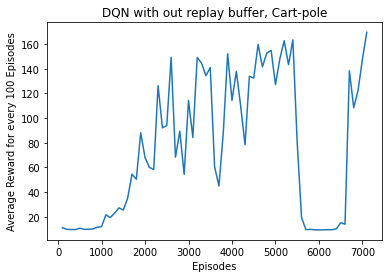

In [18]:
m = 100
n = len(dqn.episodic_rewards)//m
ep_rwd = np.reshape(dqn.episodic_rewards[:n*m],(n,m))
avg_eprwd = np.mean(ep_rwd,axis=1)
x_plot = [(i+1)*m for i in range(n)]
plt.plot(x_plot, avg_eprwd)
plt.xlabel('Episodes')
plt.ylabel('Average Reward for every '+str(m)+' Episodes')
plt.title('DQN with out replay buffer, Cart-pole')
plt.show()

In [20]:
dqn.save_model('dqn_weights_without_replay_buffer')
np.save('dqn_weights_without_replay_buffer.npy',dqn.episodic_rewards)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dqn_weights_without_replay_buffer/assets


In [21]:
# to visualize it

dqn_vis = DQN('CartPole-v0')
dqn_vis.load_model('dqn_weights_without_replay_buffer') # loading trained model from memory
for i in range(10):
    done = False
    steps = 0
    state = dqn_vis.env.reset()

    while not done and steps < 200: 
        dqn_vis.env.render()
        action = np.argmax(dqn_vis.model.predict(np.array([state]))[0])
        state, _, done, _ = dqn_vis.env.step(action)
        steps += 1
        
    print('Steps:'+str(steps))

dqn_vis.env.close()

Steps:200
Steps:200
Steps:200
Steps:200
Steps:200
Steps:200
Steps:200
Steps:200
Steps:200
Steps:200


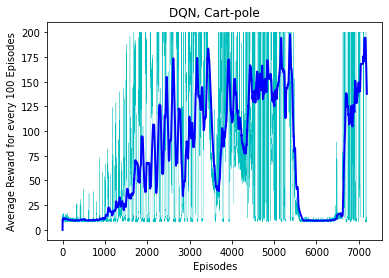

In [3]:
# to visualize it No need to train again

ep_rwd = np.load('dqn_weights_without_replay_buffer.npy') # loading training data from memory
avg_eprwd = []
tot = 0
for i in range(1,100):
    avg_eprwd.append(tot/i)
    tot += ep_rwd[i]
for i in range(100,len(ep_rwd)):
    tot += ep_rwd[i]
    tot -= ep_rwd[i-100]
    avg_eprwd.append(tot/100)
plt.plot(ep_rwd,'c',linewidth=0.3)
plt.plot(avg_eprwd,'b',linewidth=2)
plt.xlabel('Episodes')
plt.ylabel('Average Reward for every '+str(100)+' Episodes')
plt.title('DQN, Cart-pole')
plt.show()